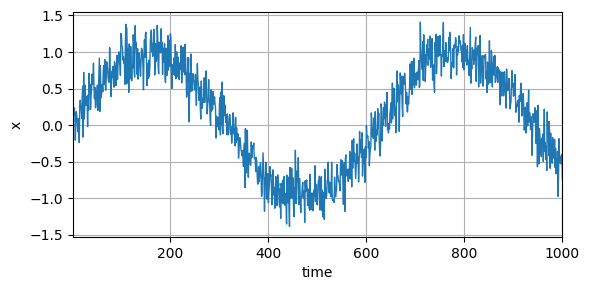

In [1]:
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))


# matplotlib 绘图实现
plt.figure(figsize=(6, 3))  # 设置图形大小
plt.plot(time.numpy(), x.numpy(), linestyle='-', linewidth=1)  # 绘制曲线（默认蓝色）
plt.xlabel('time')  # x轴标签
plt.ylabel('x')     # y轴标签
plt.xlim(1, 1000)   # x轴范围
plt.grid(True)      # 显示网格线
plt.tight_layout()  # 自动调整边距（类似d2l的默认行为）
plt.show()


In [2]:
import torch.utils.data as data
def load_array(features,batch_size, resize=None):  #@save
    dataset = data.TensorDataset(torch.tensor(features[0],dtype=torch.float32),torch.tensor(features[1],dtype=torch.float32))
    return data.DataLoader(dataset, batch_size, shuffle=True,
                            num_workers=12)
tau = 16
pred_steps = 16
features = torch.zeros((T - tau, tau))
print(features.shape)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
print(features[:,i])
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = load_array((features[:n_train], labels[:n_train]),
                            batch_size)

torch.Size([984, 16])
tensor([ 0.3384,  0.2181,  0.2160,  0.0934,  0.3915,  0.5329, -0.1642,  0.7202,
         0.0821,  0.2096,  0.5459,  0.3277,  0.2698,  0.3148,  0.3935, -0.0206,
         0.4118,  0.2080,  0.7060,  0.4631,  0.5580,  0.2155,  0.4016,  0.4765,
         0.6973,  0.5545,  0.6493,  0.8467,  0.5147,  0.3606,  0.5134,  0.2353,
         0.2530,  0.3617,  0.4722,  0.5455,  0.2006,  0.4476,  0.6720,  0.9150,
         0.1854,  0.8139,  0.4670,  0.3745,  0.4980,  0.5573,  0.4557,  0.7535,
         0.8119,  0.5585,  0.8955,  0.5601,  0.4777,  0.6514,  0.8659,  0.8256,
         0.7593,  0.6330,  0.5919,  0.5859,  1.0592,  0.7704,  0.5988,  0.3896,
         0.7357,  0.7150,  0.6496,  0.8032,  0.5629,  0.5187,  0.8663,  0.8128,
         0.8066,  0.5409,  0.6836,  0.9536,  0.6231,  0.8186,  0.9082,  1.0006,
         0.8911,  0.8182,  0.6793,  1.2519,  1.2307,  1.0821,  1.0701,  0.8904,
         0.9356,  0.8469,  0.8987,  0.5592,  1.0837,  1.3792,  0.5611,  1.3303,
         0.9751,  

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6536\1547261605.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = data.TensorDataset(torch.tensor(features[0],dtype=torch.float32),torch.tensor(features[1],dtype=torch.float32))


In [3]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(16, 64),
                        nn.ReLU(),
                        nn.Linear(64, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [4]:
def evaluate_loss(net, data_iter, loss_fn):
    """评估模型在给定数据集上的平均损失"""
    net.eval()  # 切换为评估模式（影响Dropout/BatchNorm等层）
    total_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():  # 禁用梯度计算
        for X, y in data_iter:
            y_hat = net(X)
            l = loss_fn(y_hat, y)
            total_loss += l.sum().item()  # 与训练代码保持一致的损失计算方式
            total_samples += y.shape[0]
    
    return total_loss / total_samples  # 平均样本损失

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 20, 0.01)

epoch 1, loss: 0.048467
epoch 2, loss: 0.062865
epoch 3, loss: 0.067686
epoch 4, loss: 0.046240
epoch 5, loss: 0.054091
epoch 6, loss: 0.043394
epoch 7, loss: 0.044633


KeyboardInterrupt: 

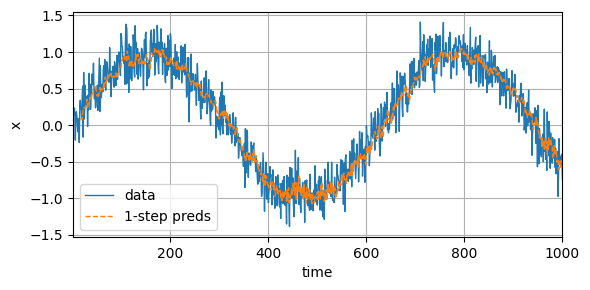

In [5]:
onestep_preds = net(features)
plt.figure(figsize=(6, 3))
# 原始数据曲线（蓝色实线）
plt.plot(time.numpy(), x.numpy(), 
         linestyle='-', linewidth=1, 
         label='data')  
# 预测数据曲线（橙色虚线）
plt.plot(time[tau:].numpy(), onestep_preds.detach().numpy(), 
         linestyle='--', linewidth=1, 
         label='1-step preds')  

plt.xlabel('time')
plt.ylabel('x')
plt.xlim(1, 1000)
plt.grid(True)
plt.legend()  # 显示图例
plt.tight_layout()
plt.show()


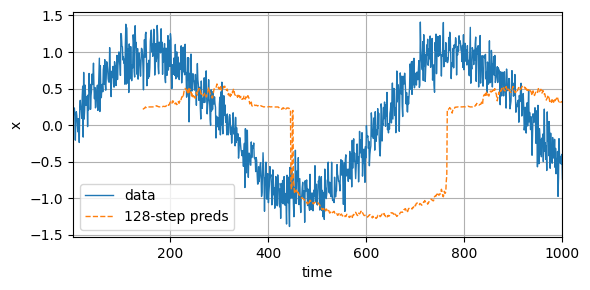

In [22]:
step=128
pred=torch.zeros((T-tau-step+1,tau+step))
# 滑动窗口预测
# for i in range(T-tau-pred_steps):   
#     label=x[i:i+tau]
#     # 获取当前窗口
#     for j in range(pred_steps):
#         label=torch.cat((label,net(label)))
#         label=label[1:]
#     pred.append(label[-1])
for i in range(tau):
    pred[:, i] = x[i: i + T - tau - step + 1]
for i in range(tau, tau + step):
    pred[:,i] = net(pred[:, i-tau:i]).squeeze()
plt.figure(figsize=(6, 3))
# 原始数据曲线（蓝色实线）
plt.plot(time.numpy(), x.numpy(), 
         linestyle='-', linewidth=1, 
         label='data')  
# 预测数据曲线（橙色虚线）
plt.plot(time[tau+step-1:].numpy(), pred[:,-1].detach().numpy(), 
         linestyle='--', linewidth=1, 
         label=f'{step}-step preds')  

plt.xlabel('time')
plt.ylabel('x')
plt.xlim(1, 1000)
plt.grid(True)
plt.legend()  # 显示图例
plt.tight_layout()
plt.show()